In [26]:
import ee
import geemap
import pprint
from matplotlib import pyplot as plt
import pandas as pd

In [27]:
# First part of the script times out if using all japan instead of small roi

In [28]:
# Initialise (don't need maybe?)
ee.Initialize()
# Configure the pretty printing output & initialize earthengine
pp = pprint.PrettyPrinter(depth=4)

In [29]:
Map = geemap.Map(center=[38,138], zoom=6)
Map.add_basemap('HYBRID')
Map

Map(center=[38, 138], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=F…

In [30]:
# Japan shp is not small, so we ingest it from personal account (otherwise we can upload locally with geemap.shp_to_ee)
japan_shp = 'users/luiscartor/japan_gadm0'
japan = geemap.ee.FeatureCollection(japan_shp)

Map.addLayer(japan, {}, 'Japan')

point = ee.Geometry.Point([38,138])
Map.addLayer(point, {}, 'Point')

### Draw polygon for ROI

In [31]:
roi = ee.FeatureCollection(Map.draw_features)

## Adding Landsat collections

In [32]:
# Function to add year attribute
def addyear(img):
    return img.set('year', ee.Image(img).date().get('year'))

# Function to add Day Of Year attribute
def addDOY(img):
    return img.set('DOY', ee.Image(img).date().getRelative('day', 'year'))

# Landsat 5
L5col = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
    .filterBounds(roi) \
    .select('B[1-7]','pixel_qa') \
    .map(addyear) \
    .map(addDOY)
#.filterDate('1990-01-01', '1991-12-31') \
       
#print(L5col.getInfo())

# Landsat 7
L7col = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
    .filterBounds(roi) \
    .select('B[1-7]','pixel_qa') \
    .map(addyear) \
    .map(addDOY) 
#.filterDate('2005-01-01', '2006-12-31') \    
#print(L7col)

### Check collections properties

In [33]:
# Get the number of images
countL5 = L5col.size()
print('L5 Count: ', str(countL5.getInfo())+'\n')

countL7 = L7col.size()
print('L7 Count: ', str(countL7.getInfo())+'\n')

# Get the number of images per year
# Define a list of unique observation years from the image collection.
yearsL5 = ee.List(L5col.aggregate_array('year')).distinct().sort();
print('L5 Years:', str(yearsL5.getInfo())+'\n')
yearsL7 = ee.List(L7col.aggregate_array('year')).distinct().sort();
print('L7 Years:', str(yearsL7.getInfo())+'\n')


L5 Count:  262

L7 Count:  370

L5 Years: [1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]

L7 Years: [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]



In [34]:
# Map over the list of years to build a list of annual image composites.
# Function to creat comp list
def yearimlistL5(year):
    return L5col.filterMetadata('year', 'equals', year).size()

imagesperyearL5 = yearsL5.map(yearimlistL5)
print('Images per year L5:', str(imagesperyearL5.getInfo())+'\n')

def yearimlistL7(year):
    return L7col.filterMetadata('year', 'equals', year).size()

imagesperyearL7 = yearsL7.map(yearimlistL7)
print('Images per year L7:', str(imagesperyearL7.getInfo())+'\n')

Images per year L5: [7, 6, 7, 12, 5, 10, 17, 8, 12, 13, 6, 9, 15, 8, 9, 10, 7, 4, 1, 15, 9, 13, 15, 14, 13, 9, 8]

Images per year L7: [4, 13, 16, 19, 14, 18, 14, 15, 18, 21, 15, 16, 14, 21, 16, 12, 13, 19, 17, 27, 28, 20]



### Plot images per year

In [35]:
# Create vectors from year and images x year lists
imxyearL5vec = [[i] for i in imagesperyearL5.getInfo()]
#imxyearL5vec

yearsL5vec = [[i] for i in yearsL5.getInfo()]
#yearsL5vec

imxyearL7vec = [[i] for i in imagesperyearL7.getInfo()]
#imxyearL7vec

yearsL7vec = [[i] for i in yearsL7.getInfo()]
#yearsL7vec

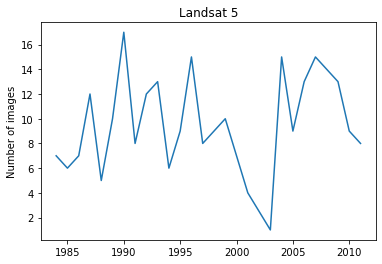

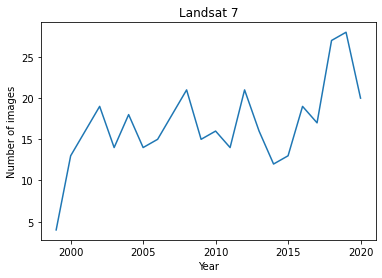

In [36]:
# Plots
plt.plot(yearsL5vec,imxyearL5vec)
plt.title('Landsat 5')
plt.ylabel('Number of images')
plt.show()

plt.plot(yearsL7vec,imxyearL7vec)
plt.title('Landsat 7')
plt.ylabel('Number of images')
plt.xlabel('Year')
plt.show()

# Collection pre-processing
### Masking functions

In [37]:
# Function to mask clouds, cloud shadow and snow, based on the pixel_qa band of Landsat SR data

In [38]:
# Parameters for masking function (move to preamble)

def landsatmasking(img):

  qa = img.select('pixel_qa')
  # If the cloud bit (5) is set and the cloud confidence (7) is high
  # or the cloud shadow bit is set (3), then it's a bad pixel.
  cloudorsnow = qa.bitwiseAnd(1 << 5). \
    And(qa.bitwiseAnd(1 << 7)). \
    Or(qa.bitwiseAnd(1 << 3)). \
    Or(qa.bitwiseAnd(1 << 4))  
  # Remove edge pixels that don't occur in all bands
  mask2 = img.mask().reduce(ee.Reducer.min())
  return img.updateMask(cloudorsnow.Not()).updateMask(mask2)




In [39]:
# L5 Collection: cloud masking + snow masking
L5col_masked = L5col.map(landsatmasking)

# L7 Collection: cloud masking + snow masking
L7col_masked = L7col.map(landsatmasking)

In [40]:
Map2 = geemap.Map(center=[38,138], zoom=6)
Map2.add_basemap('HYBRID')
Map2

Map(center=[38, 138], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=F…

In [41]:
# Visualization properties
L5_vis = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0.0,
    'max': 3000.0,
    'gamma': 1.4,
}
# Add layer
#Map2.addLayer(L5col.first(), L5_vis, 'L5_first')
#Map2.addLayer(L5col_masked.first(), L5_vis, 'L5_masked')



#Map2.addLayer(L7col.first(), L5_vis, 'L7_first')
#Map2.addLayer(L7col_masked.first(), L5_vis, 'L7_masked')

# Spectral indeces extraction

In [42]:
# Spectral indices function. Adds index as a new band to every image
def addINDICES(img):
    
    ndvi = img.normalizedDifference(['B4', 'B3']).rename('NDVI')
    lswi = img.normalizedDifference(['B4', 'B5']).rename('LSWI')
    ndsi = img.normalizedDifference(['B2', 'B5']).rename('NDSI')
    
    # I multiply by scale factor for EVI (DIDNT WORK TO SOLVE HIGH VALUES ISSUE)
    evi = img.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': img.select('B4').multiply(0.0001),
      'RED': img.select('B3').multiply(0.0001),
      'BLUE': img.select('B1').multiply(0.0001)
    }).rename('EVI')
    
    return img.addBands(ndvi).addBands(lswi).addBands(ndsi).addBands(evi)

# Calculate indices to collections
L5col_indices = L5col_masked.map(addINDICES)
L7col_indices = L7col_masked.map(addINDICES)


In [43]:
# Visualize indices
index_vis = {
    'bands': ['EVI'],
    'min': 0.0,
    'max': 1.0,
    'gamma': 1.4,
}

Map2.addLayer(L7col_indices.median(), index_vis, 'L5_evi')

#Map2.addLayer(L7col_indices.median(), {'bands': ['NDVI'],'min': 0.0,'max': 1.0,'gamma': 1.4}, 'L5_ndvi')
#Map2.addLayer(L7col_indices.median(), {'bands': ['LSWI'],'min': 0.0,'max': 1.0,'gamma': 1.4}, 'L5_lswi')

## Merge collections and subset to indeces

In [44]:
# Define periods names
periodnames = {'8590','9094','9599','0004','0509','1014','1520'}

# Merge collections (if not merged at the beginning)
L57col = L5col_indices.merge(L7col_indices)

# Subset to spectral indices
L57col_ind = L57col.select('NDVI','LSWI','NDSI','EVI')


# Maybe here loop for each period!!!

# Subset to 5-year periods
L57_8589 = L57col_ind.filterDate('1985-01-01', '1989-12-31')
L57_9094 = L57col_ind.filterDate('1990-01-01', '1994-12-31')
L57_9599 = L57col_ind.filterDate('1995-01-01', '1999-12-31')
L57_0004 = L57col_ind.filterDate('2000-01-01', '2004-12-31')
L57_0509 = L57col_ind.filterDate('2005-01-01', '2009-12-31')
L57_1014 = L57col_ind.filterDate('2010-01-01', '2014-12-31')
L57_1520 = L57col_ind.filterDate('2015-01-01', '2019-12-31')

# Dictionary with periods and collections
periods_dict = {'8590': L57_8589,
              '9094': L57_9094,
              '9599': L57_9599,
              '0004': L57_0004,
              '0509': L57_0509,
              '1014': L57_1014,
              '1520': L57_1520}

KeyboardInterrupt: 

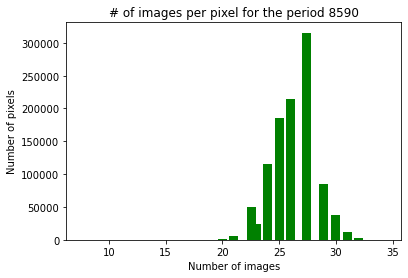

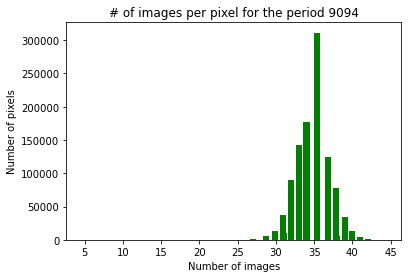

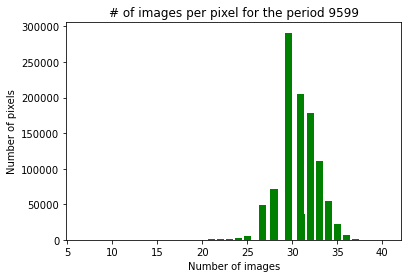

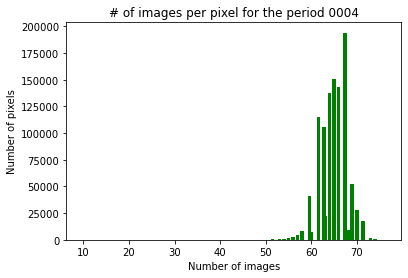

In [45]:
# Study available images per period per pixel
# Function to get date
def addDATE(img):

    return ee.Image.constant(img.date().getRelative('day', 'year')).int().updateMask(img.select(0).mask())


# Loop for all periods
#periods = [L57_8589,L57_9094]

#for period in periods:
for periodcol in periods_dict.values():
    
    # Obtain number of images per year; avoid same date pixels (different tile but same date), we count disctinct dates
    freq = periodcol.map(addDATE).reduce(ee.Reducer.countDistinct())

    # Visualize map
    Map2.addLayer(freq, {'bands': ['constant_count'],'min':0,'max':50,'palette': ['00FFFF', '0000FF']}, 
                  'Im. Frequency period: ' + list(periods_dict.keys())[list(periods_dict.values()).index(periodcol)])


    # Histogram of number of images per pixel
    histogram = freq.reduceRegion(**{
      'reducer': ee.Reducer.histogram(),
      'geometry': roi.geometry(),
      'scale': 30,
      'maxPixels': 1e9
    })

    #print(histogram.getInfo())

    # Convert histogram (dictionary type) into list
    hist = histogram.getInfo()
    hist_list = list(hist.values())

    # Plot histogram
    plt.figure()  # This is needed to plot multiple figures in plot
    plt.bar(hist_list[0]['bucketMeans'], hist_list[0]['histogram'], color='g')
    plt.ylabel('Number of pixels')
    plt.xlabel('Number of images')
    plt.title('# of images per pixel for the period '+ list(periods_dict.keys())[list(periods_dict.values()).index(periodcol)])
    
    # Save figure
    plt.savefig('../Japan_mapping/results/figures/imgavailability_period'+
                list(periods_dict.keys())[list(periods_dict.values()).index(periodcol)]+'_hist.eps', bbox_inches="tight")

# Mapping for different prefectures

In [ ]:
# List of prefectures with flooding data
prefectures_table = '../Japan_mapping/data/prefecturesdata.csv'
prefsdata = pd.read_csv(prefectures_table, sep=",")
# shows top 10 rows
#prefsdata.head(10)
prefsdata

In [ ]:
# List of prefectures with DOY per temperature data
temperature_table = '../Japan_mapping/data/prefecturetempdata.csv'
tempdata = pd.read_csv(temperature_table, sep=",")
# shows top 10 rows
#tempdata.head(10)
tempdata

In [ ]:
Map = geemap.Map(center=[38,138], zoom=6)
Map.add_basemap('HYBRID')
Map

In [ ]:
# Load prefecture shapefile (from GEE account)
prefs_shp = 'users/luiscartor/japan_gadm1'
prefs = geemap.ee.FeatureCollection(prefs_shp)

Map.addLayer(prefs, {}, 'Prefectures')

## Loop for each period and prefecture

In [ ]:
# Data frame to store image availability
availabilitytable = pd.DataFrame([])

# List to store prefectural rice maps
prefmapslist = list()

# Select prefecture polygon based on table name
#prefecture = prefsdata['Prefecture'][0]
# periodcol = L57_8589

# Loop for each period
for periodcol in periods_dict.values():

    # Loop for each prefecture
    for prefecture in prefsdata['Prefecture']:

        # Extract prefecture polygon
        prefpolygon = prefs \
            .filter(ee.Filter.eq("NAME_1", prefecture)) 

        #Map.addLayer(Ibaraki, {}, 'Ibaraki')
        #print(prefecture)
        #print(list(periods_dict.keys())[list(periods_dict.values()).index(periodcol)])

In [ ]:
prefecture = prefsdata['Prefecture'][0]
periodcol = L57_8589

# Extract flooding periods
# Flooding start day is considered the first day of transplanting (TS)
flood_start = int(prefsdata['startdate'][prefsdata[prefsdata['Prefecture']==prefecture].index[0]])
# Flooding last day is considered the end day of transplanting + 30 days
flood_end = int(prefsdata['enddate'][prefsdata[prefsdata['Prefecture']==prefecture].index[0]] + 30)

print(flood_start)
print(flood_end)

# Extracting DOY for temperature data
TGS0S = int(tempdata['TGS-0-S'][prefsdata[prefsdata['Prefecture']==prefecture].index[0]])
TGS0E = int(tempdata['TGS-0-E'][prefsdata[prefsdata['Prefecture']==prefecture].index[0]]) 
TGS5S = int(tempdata['TGS-5-S'][prefsdata[prefsdata['Prefecture']==prefecture].index[0]]) 
TGS5E = int(tempdata['TGS-5-E'][prefsdata[prefsdata['Prefecture']==prefecture].index[0]]) 
TGS10S = int(tempdata['TGS-10-S'][prefsdata[prefsdata['Prefecture']==prefecture].index[0]]) 
TGS10E = int(tempdata['TGS-10-E'][prefsdata[prefsdata['Prefecture']==prefecture].index[0]])

In [ ]:
# List for each period (year period and irrigation period)
# Subset to flooding period
periodcol_flood = periodcol.filter(ee.Filter.gte('DOY', flood_start)).filter(ee.Filter.lte('DOY', flood_end))

#periodcol_test = periodcol.filter(ee.Filter.calendarRange(flood_start, flood_end))

# Subset to non-flooding period
periodcol_noflood1 = periodcol.filter(ee.Filter.lte('DOY', flood_start))
periodcol_noflood2 = periodcol.filter(ee.Filter.gte('DOY', flood_end))
periodcol_noflood = periodcol_noflood1.merge(periodcol_noflood2)

# Print number of images per season
print('Number of Images during non-flooding season for', prefecture, 
      'for the period', list(periods_dict.keys())[list(periods_dict.values()).index(periodcol)], 
      str(periodcol_flood.size().getInfo())+'\n')
print('Number of Images during non-flooding season for', prefecture, 
      'for the period', list(periods_dict.keys())[list(periods_dict.values()).index(periodcol)],
      str(periodcol_noflood.size().getInfo())+'\n')

# Add number of images per season and period into table
d = {'Prefecture': [prefecture], 
     'Lustrum': [list(periods_dict.keys())[list(periods_dict.values()).index(periodcol)]], 
     'AvImFlooding': [periodcol_flood.size().getInfo()], 
     'AvImNonFlooding': [periodcol_noflood.size().getInfo()]} 
availabilitytable_pref = pd.DataFrame(data=d)

# Add prefecture to table
availabilitytable = availabilitytable.append(availabilitytable_pref)

print(availabilitytable_pref)
print(availabilitytable)


#periodcol_flood = periodcol.filter(ee.Filter.dayOfYear(flood_start, flood_end)).first()
#Map.addLayer(periodcol_flood, {}, 'floodcol')


# Create Histogram of availability per pixel and map!
freq = periodcol_flood.reduce(ee.Reducer.countDistinct())

# Histogram of number of images per pixel
histogram = freq.reduceRegion(**{
  'reducer': ee.Reducer.histogram(),
  'geometry': prefpolygon.geometry(),
  'scale': 30,
  'maxPixels': 1e9
})

# Convert histogram (dictionary type) into list
hist = histogram.getInfo()
hist_list = list(hist.values())

# Plot histogram
plt.figure()  # This is needed to plot multiple figures in plot
plt.bar(hist_list[0]['bucketMeans'], hist_list[0]['histogram'], color='g')
plt.ylabel('Number of pixels')
plt.xlabel('Number of images')
plt.title('# of images per pixel for the period '+ list(periods_dict.keys())[list(periods_dict.values()).index(periodcol)]+
         ' for ' + prefecture)
# Save figure
plt.savefig('../Japan_mapping/results/figures/floodimageavailability_period'+
            list(periods_dict.keys())[list(periods_dict.values()).index(periodcol)]+
            '_'+prefecture+'_hist.eps', bbox_inches="tight")

In [ ]:
# Subset to period between first 0 and last 0 min degrees:
L57_0S0E = periodcol.filter(ee.Filter.gte('DOY', TGS0S)).filter(ee.Filter.lte('DOY', TGS0E))

# Subset to period between first 5 and last 5 min degrees:
L57_5S5E = periodcol.filter(ee.Filter.gte('DOY', TGS5S)).filter(ee.Filter.lte('DOY', TGS5E))

# Subset to period between first 0 and first 10 min degrees:
L57_0S10S = periodcol.filter(ee.Filter.gte('DOY', TGS0S)).filter(ee.Filter.lte('DOY', TGS10S))

# Subset to period between first 10 + 40days and last 10 min degrees:
L57_10S40to5E = periodcol.filter(ee.Filter.gte('DOY', TGS10S+40)).filter(ee.Filter.lte('DOY', TGS10E))

# Subset to period between last 10 and first 10 (not thermal growing season)
L57_10E10S1 = periodcol.filter(ee.Filter.lte('DOY', TGS10S))
L57_10E10S2 = periodcol.filter(ee.Filter.gte('DOY', TGS10E))
L57_10E10S = L57_10E10S1.merge(L57_10E10S2)

In [ ]:
Map3 = geemap.Map(center=[38,138], zoom=6)
Map3.add_basemap('HYBRID')
Map3

In [ ]:
# Calculate median value for indeces for rice flooding period
L57_flood_median = periodcol_flood.median()

# Median
L57_5S5E_median = L57_5S5E.median()


In [ ]:
# MASKS (based on Dong 2016, RSE)

# Mask 1) Sparce vegetation: soil, built-up, water body, low vegetated lands. max EVI (T5S-T5E) < 0.6
# I could use some percentile, instead of max, in order to avoid outliers
L57_5S5E_median = L57_5S5E.median()
L57_5S5E_max = L57_5S5E.max()

mask1 = L57_5S5E_max.select('EVI').lt(0.5)

In [ ]:
# Mask 2) Natural vegetation mask: forests, natural wetlands, grass. Max EVI (T10E-T10S) > 0.4
L57_10E10S_median = L57_10E10S.median()
L57_10E10S_max = L57_10E10S.max()

mask2 = L57_10E10S_median.select('EVI').gt(0.2)

#SOLVE ISSUE: EVI GIVING VALUES ABOVE 2!

In [ ]:
# Mask 3) Forest mask (JAXA)
# Starts from 2007
forestdataset = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF') \
    .filterDate('2017-01-01', '2017-12-31')
    
# Forest is the fnf = 1
forest = forestdataset.first().select('fnf').eq(1);

# Create forest mask
mask3 = forest

# MASK 3 NOT WORKING VERY WELL. ALOS MAP GETS A LOT OF FALSE POSITIVE FOREST (REDUCING RICE FIELDS)

In [ ]:
# Mask 4) Slope: larger than 3deg

# Call SRTM elevation dataset
elevdataset = ee.Image('JAXA/ALOS/AW3D30/V2_2');
elevation = elevdataset.select('AVE_DSM');

# Obtain 
slope = ee.Terrain.slope(elevation);

# Create mask ro slope > 3 deg
mask4 = slope.gt(3)

In [ ]:
# Method 2 for classifying based on % of images
# Add band to each image for rice classification
# Function to add a band of rice classification to each image in the col
# Rule for rice is that LSWI − NDVI > 0 or LSWI − EVI > 0
def addRICE(img):    
    rice = img.expression(
    "(lswi - ndvi > 0) || (lswi - evi > 0) ? 1\
    :2",{'lswi': img.select('LSWI'),'ndvi': img.select('NDVI'),'evi': img.select('EVI')}).rename('RICE')
    
    return img.addBands(rice)

#rice = L57_flood_median.expression(
#    "(lswi - ndvi > 0) || (lswi - evi > 0) ? 1\
#    :2",{'lswi': L57_flood_median.select('LSWI'),'ndvi': L57_flood_median.select('NDVI'),'evi': L57_flood_median.select('EVI')})
  


    
# APPLY MASKS!
def landcovermasking(img):
  return img.updateMask(mask1.Not()).updateMask(mask2.Not()).updateMask(mask3.Not()).updateMask(mask4.Not())


periodcol_flood_masked =  periodcol_flood.map(landcovermasking)

    
periodcol_ricecol = periodcol_flood_masked.map(addRICE).select('RICE')

# Now we apply the % of images threshold to classify as rice
def classornot(img):
    return img.eq(1)
    
# Reduce the number of images with classornot pixels
riceprop = periodcol_ricecol.map(classornot).mean()

# Select % of image necessary to assing rice!
riceclass = riceprop.gte(0.1).clip(prefpolygon)

# Insert map in list
prefmapslist.append(riceclass)

print(len(prefmapslist))
#prefmapslist = list()

periodcol = ee.ImageCollection.fromImages(prefmapslist)
print(periodcol.size().getInfo())

periodmosaic = periodcol.mosaic()
Map3.addLayer(periodmosaic, {}, 'mosaic')

In [ ]:
index_vis = {
    'bands': ['EVI'],
    'min': 0.0,
    'max': 2.0,
    'gamma': 1.4,
}

Map3.addLayer(L57_10E10S_median, index_vis, 'EVI')
Map3.addLayer(mask1, {}, 'mask1')
Map3.addLayer(mask2, {}, 'mask2')
Map3.addLayer(mask3, {}, 'mask3')
Map3.addLayer(mask4, {}, 'mask4')
#Map3.addLayer(slope, {}, 'slope')
#Map3.addLayer(ricefinal, {}, 'finalmap')
Map3.addLayer(riceclass, {}, 'rice')

# Join maps: Japan paddy field maps 

# Save to disk

In [ ]:
# Save availabilitytable!

# Accuracy assessment

In [ ]:
# IMPERVIOUS AND BARREN
# Rule for impervious and barren is LSWI < 0 
def addIMPERV(img):    
    imperv = img.expression(
    "(lswi < 0) ? 1\
    :2",{'lswi': img.select('LSWI')}).rename('IMPERV')
    
    return img.addBands(imperv)

L57_8589_impervcol = L57_5S5E.map(addIMPERV).select('IMPERV')

# Now we apply the % of images threshold to classify as rice
def classornot(img):
    return img.eq(1)

# Reduce the number of images with classornot pixels
impervprop = L57_8589_impervcol.map(classornot).mean()
# Select % of image necessary to assing imperv
impervclass = impervprop.gte(0.5)

# EVERGREEN
# Rule for evergreen is LSWI > 0 
def addEVER(img):    
    ever = img.expression(
    "(lswi > 0) ? 1\
    :2",{'lswi': img.select('LSWI')}).rename('EVER')
    
    return img.addBands(ever)

L57_8589_evercol = L57_8589.map(addEVER).select('EVER')

# Now we apply the % of images threshold to classify ever
def classornot(img):
    return img.eq(1)

# Reduce the number of images with classornot pixels
everprop = L57_8589_evercol.map(classornot).mean()
# Select % of image necessary to assing imperv
everclass = everprop.gte(0.9)